In [2]:
# !pip install imageai
# from imageai.Detection import ObjectDetection

# !pip install tensorflow
import tensorflow as tf
tf.__version__

# try:
#   # %tensorflow_version only exists in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass
# import tensorflow as tf

'2.11.1'

In [3]:
# !pip install git+https://github.com/tensorflow/examples.git

In [4]:
# !git clone https://github.com/tensorflow/examples.git
!pip install tensorflow_examples

In [5]:
!pip install tensorflow-datasets

In [6]:
!pip install matplotlib

In [7]:

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
# import tensorflow_datasets as С
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt


import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

/Users/annvorosh/miniforge3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the ColorectalHistology dataset

The dataset is the standard dataset for TensorFlow

In [8]:
dataset, info = tfds.load(name='lost_and_found', with_info=True)


In [9]:
# img_path = '../Users/annvorosh/Documents/GB/NeuralNetwork/NN_06/leftImg8bit/train'
# mask_path = '../Users/annvorosh/Documents/GB/NeuralNetwork/NN_06/gtCoarse/train'

# http://wwwlehre.dhbw-stuttgart.de/~sgehrig/lostAndFoundDataset/index.html

The following code will perform a simple data augmentation by flipping the images. In addition, the image will be normalized to 0 and 1. The pixels of the segmentation mask will be labeled {1, 2, 3}, but for convenience, 1 will be subtracted from this digital series and the result will be {0, 1, 2}

In [10]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [21]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image_left'], (256, 256))
    input_mask = tf.image.resize(datapoint['segmentation_label'], (256, 256))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

# -------------------------------------------
    else:
        input_image = tf.image.rot90(input_image)
        input_mask = tf.image.rot90(input_mask)
# -------------------------------------------


    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
  
  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels


# Other options for augmentation
#       tf.image.flip_left_right
#       tf.image.flip_up_down
# 		tf.image.random_flip_left_right
# 		tf.image.random_flip_up_down
# 		tf.image.rot90
# 		tf.image.transpose

In [25]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image_left'], (256, 256))
    input_mask = tf.image.resize(datapoint['segmentation_label'], (256, 256))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image_left'], (256, 256))
    input_mask = tf.image.resize(datapoint['segmentation_label'], (256, 256), 
#                                  method = tf.image.ResizeMethod.NEAREST_NEIGHBOR
                                )

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [26]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 32
BUFFER_SIZE = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [27]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [28]:
# !pip install pillow

In [29]:
# !pip install Image
# from PIL import Image
from tensorflow.keras.preprocessing.image import array_to_img

import sys
from PIL import Image
sys.modules['Image'] = Image 

In [30]:
from PIL import Image
print(Image.__file__)

import Image
print(Image.__file__)

/Users/annvorosh/miniforge3/envs/tf/lib/python3.9/site-packages/PIL/Image.py
/Users/annvorosh/miniforge3/envs/tf/lib/python3.9/site-packages/PIL/Image.py


In [31]:
# Давайте посмотрим на пример изображения из датасета и соотвествующую ему маску из датасета.
def display(display_list):
    plt.figure(figsize=(15, 30))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()


In [32]:
train_batches = (
    train
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test.batch(BATCH_SIZE)

2023-04-03 14:08:59.996288: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


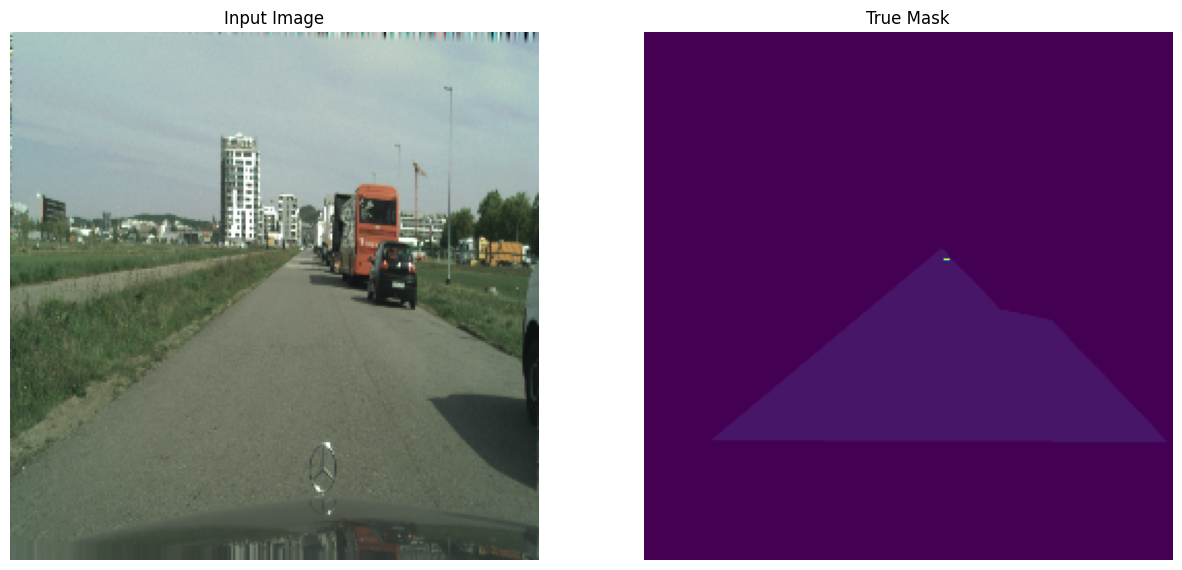

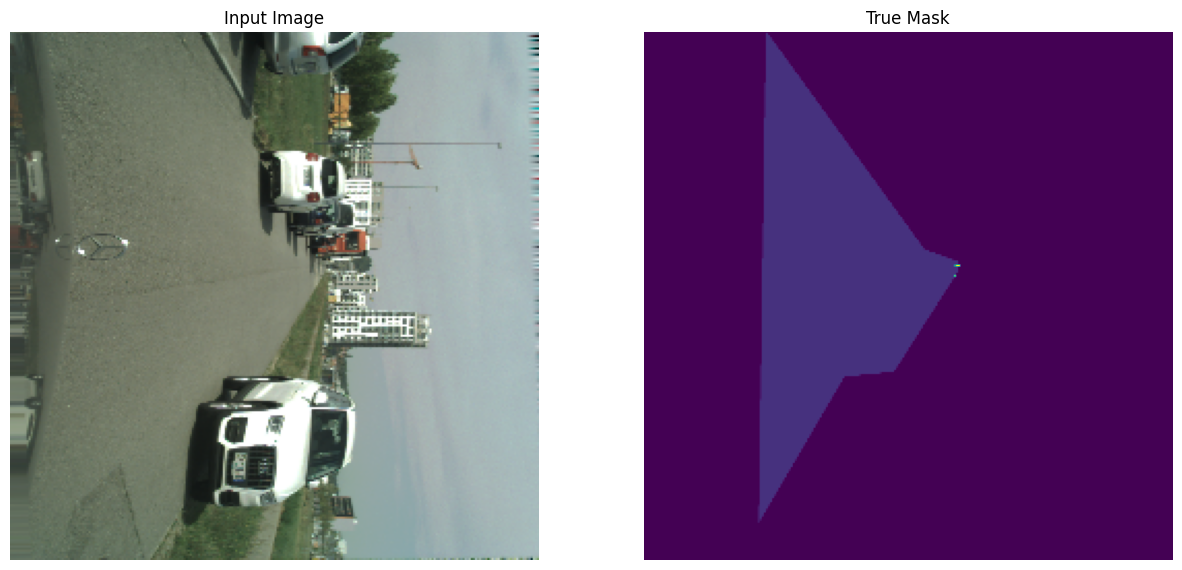

2023-04-03 14:09:04.394303: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [33]:
for images, masks in train_batches.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

## Определение модели

Будем использовать модифицированный U-Net. В качестве энкодера будет использоваться предтренированный MobileNetV2.
Декодером будет апсемпл блок уже имплементированный в TensorFlow examples [Pix2pix tutorial](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py).

Причина по который будет испольваться три канала заключается в том что у нас 3 возможных лейбла на каждый пиксель. Можно это воспринимать как классиификацию где кажедый пиксель будет принадлежать одному из трех классов.

In [34]:
# !pip install -q git+https://github.com/tensorflow/examples.git
# !pip install tensorflow_examples

In [35]:
OUTPUT_CHANNELS = 3

In [36]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [37]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]


In [38]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    x = inputs

  # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

## Тренировка модели
Now, all that is left to do is to compile and train the model. The loss being used here is `losses.SparseCategoricalCrossentropy(from_logits=True)`. The reason to use this loss function is because the network is trying to assign each pixel a label, just like multi-class prediction. In the true segmentation mask, each pixel has either a {0,1,2}. The network here is outputting three channels. Essentially, each channel is trying to learn to predict a class, and `losses.SparseCategoricalCrossentropy(from_logits=True)` is the recommended loss for 
such a scenario. Using the output of the network, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

Теперь, все что осталось это скомпилировать модель и начать процесс ее тренировки. Loss-функция, которую будем использовать - `losses.SparseCategoricalCrossentropy(from_logits=True)`. Причина использования данной loss-функции заключается в том, что нейросеть пытается назначить каждому пикселю лейбл, также как в задачах предсказания класса. Для модели в которой 3 каннала каждый из которых пытается предсказать класс `losses.SparseCategoricalCrossentropy(from_logits=True)` обычно также рекомендуется.
На выходе нейросети каждому пикселю назначается лейбл с наибольшим значением. Это то, что делает функция create_mask.


In [135]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='Ftrl',
              loss=tf.keras.losses.KLDivergence(),
              metrics=['top_k_categorical_accuracy'])


In [136]:
# !pip install pydot

In [137]:
# !pip install graphviz

In [138]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Давайте попробуем сделать предсказание с помощью нашей модели до того как началось обучение.

In [139]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [140]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
        create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 3s 3s/step


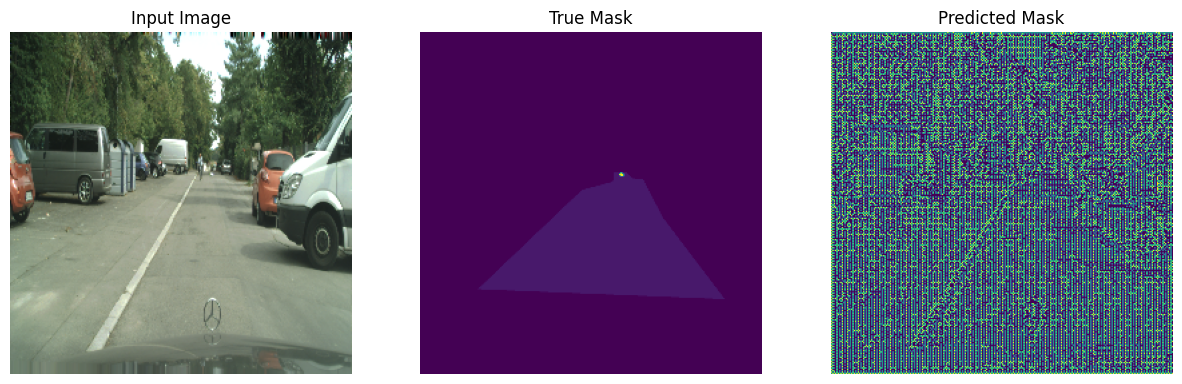

1/1 [==============================] - 1s 1s/step


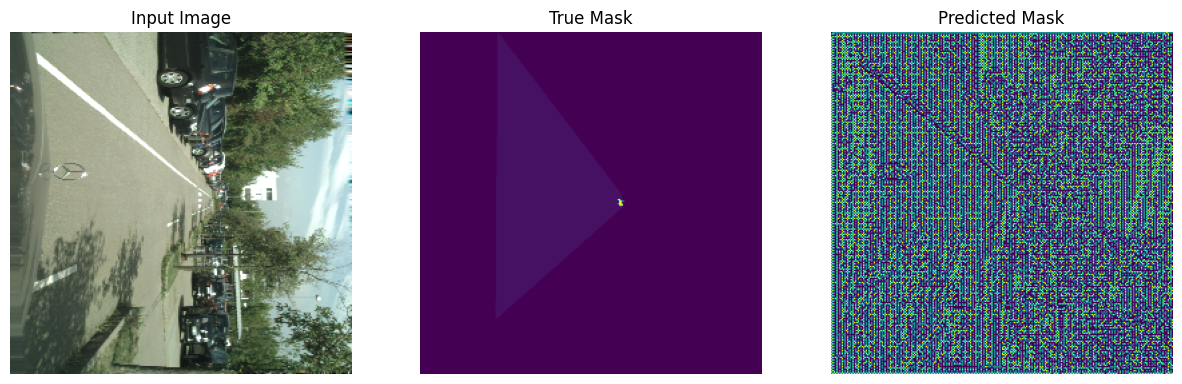

In [141]:
show_predictions(train_batches, 2)

Давайте осуществлять мониторинг того как улучшается работа модели в процессе обучения. Для завершения этой задачи callback функция определена ниже.

In [142]:
class DisplayCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


In [143]:
iopub_data_rate_limit=1.0e10

1/1 [==============================] - 0s 52ms/step


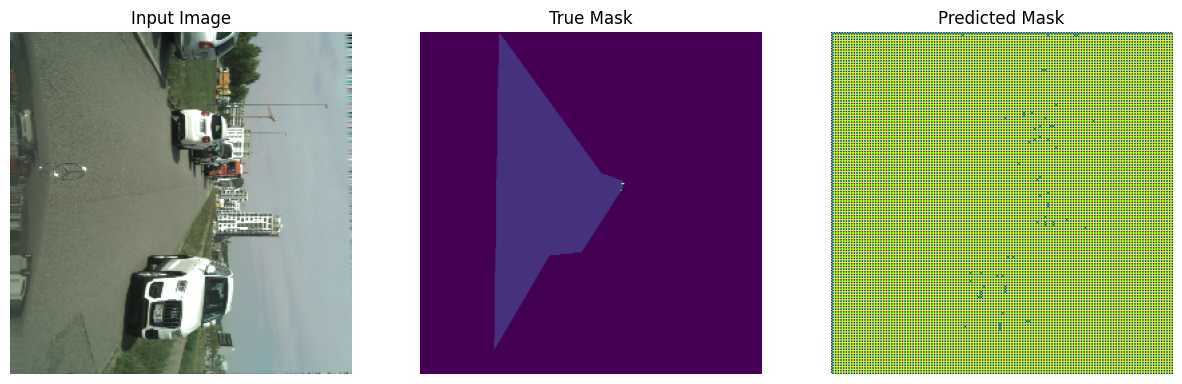


Sample Prediction after epoch 20

32/32 [==============================] - 59s 2s/step - loss: 0.0017 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.0019 - val_top_k_categorical_accuracy: 1.0000


In [144]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

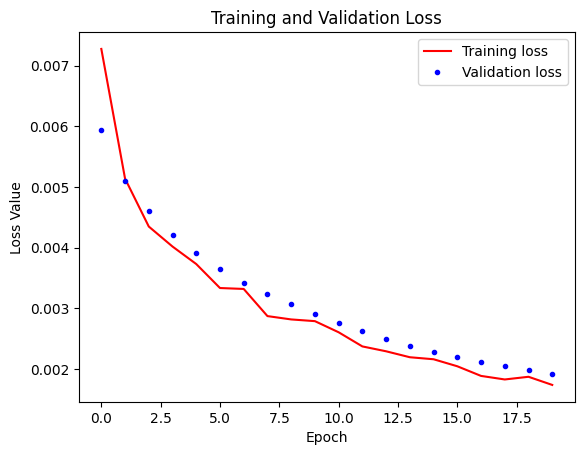

In [148]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b.', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim()
plt.legend()
plt.show()

1/1 [==============================] - 2s 2s/step


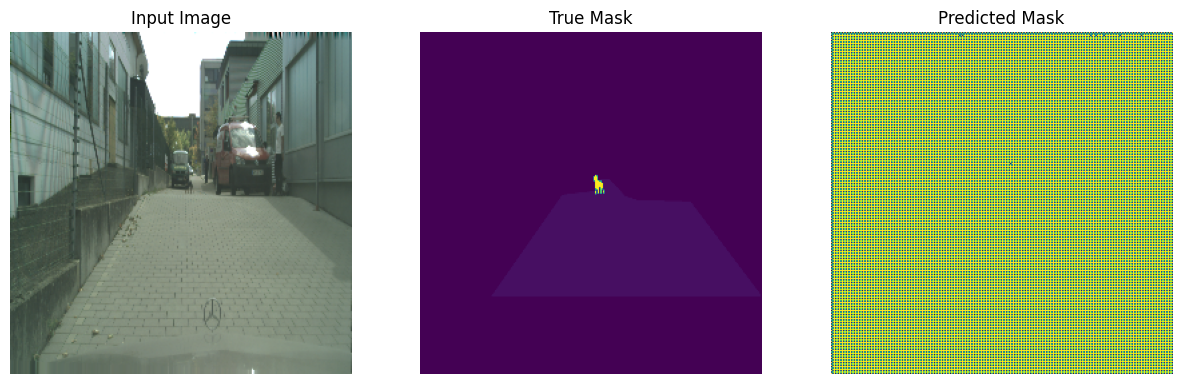

1/1 [==============================] - 1s 1s/step


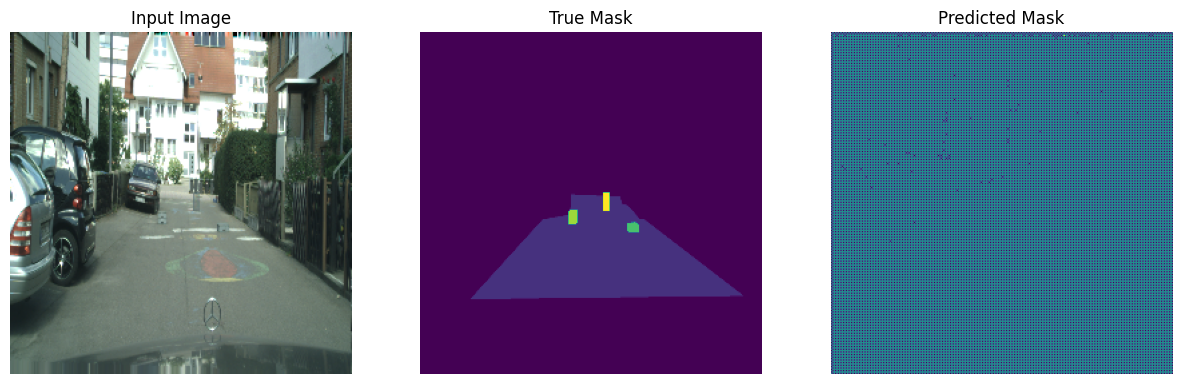

1/1 [==============================] - 1s 931ms/step


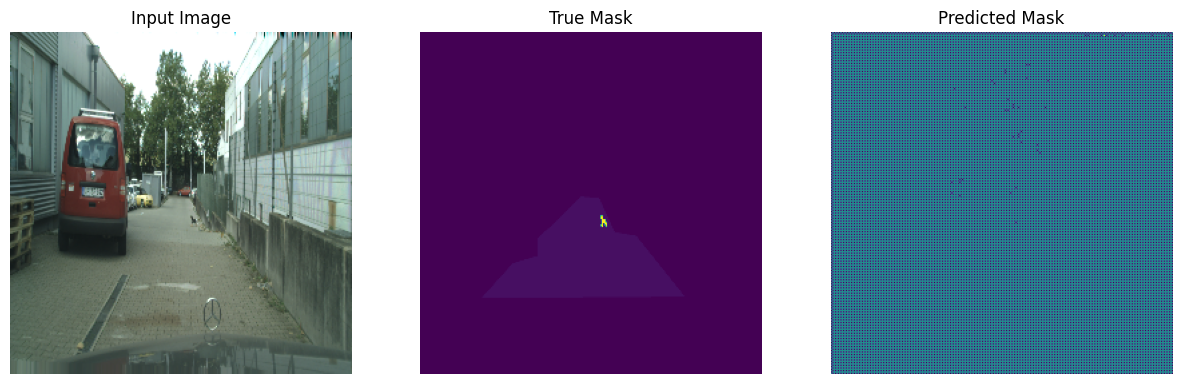

In [146]:
show_predictions(test_batches, 3)